<h1> Data analysis of Mutiny fault / error injection campaign </h1>

<h3>Imports</h3>

In [1]:
# libraries
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# make plots interactable
%matplotlib widget

<h2> Load data </h2>

In [2]:
# Base directory where data is stored
# base_dir = 'Q:/Marcello/thesis/paper/Prometheus_subset'
base_dir = 'Q:/Mutiny'
pattern = r'[0-9_]'

# Function to load data from a file
def load_metrics_data(file_path):
    data = []
    metric_name_base = os.path.basename(file_path).split('{')[0].replace("(", " ")
    
    with open(file_path, 'r', encoding="utf-8") as file:
        for line in file:
            if 'OFFSET' in line:
                continue
            
            try:
                # Replace single quotes with double quotes only outside the JSON structure
                safe_line = re.sub(r"(?<!\\)'", '"', line)
                
                # Convert the JSON-like string to a Python dictionary
                metric_data = json.loads(safe_line)
                metric = metric_data['metric']
                
                if '__name__' not in metric:
                    metric['__name__'] = metric_name_base
                    
                    if metric_name_base in ["sum rate apiserver_request_total", "sum rate rest_client_requests_total"]:
                        metric['status_code'] = "200" if "2" in os.path.basename(file_path) else "400/500"
                        
                        # Extract job or kubernetes_pod_name based on metric name
                        if metric_name_base == "sum rate apiserver_request_total":
                            job_match = re.search(r"job=_([^_]+)_", os.path.basename(file_path))
                            if job_match:
                                metric['job'] = job_match.group(1)
                        else:
                            pod_match = re.search(r"kubernetes_pod_name=_([^_]+)_", os.path.basename(file_path))
                            if pod_match:
                                metric['kubernetes_pod_name'] = pod_match.group(1)
                
                data.append(metric_data)
            except json.JSONDecodeError:
                continue
                
    return data

# Function to traverse directories and load data
def load_all_data(base_dir):
    all_data = []
    
    for root, dirs, files in os.walk(base_dir):
        condition_path = os.path.basename(os.path.dirname(os.path.dirname(root))).capitalize()
        is_baseline = condition_path == "Baselines"
        
        if not is_baseline: # baseline's and other's metrics have different paths
            condition_path = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(root))))
            
            if condition_path == "less_resources":
                condition_path = "LeR"
            elif condition_path == "more_resources":
                condition_path = "MoR"
            elif condition_path == "network":
                condition_path = "Net"
        
        workload_path = os.path.basename(os.path.dirname(root))
        workload_name = re.sub(pattern, '', workload_path)

        for file in files:
            if 'DS_Store' in file: # MacOS useless files
                continue
            
            file_path = os.path.join(root, file)
            metric_data = load_metrics_data(file_path)
            
            for entry in metric_data:
                entry['condition'] = condition_path
                entry['workload'] = workload_name
                all_data.append(entry)
                
    return all_data

# Load the data
data = load_all_data(base_dir)

<h2> Data aggregation </h2>

In [3]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)

# Clean the data frame

# Convert 'value' from string to float and extract timestap
df['timestamp'] = df['value'].apply(lambda x: x[0])
df['value'] = df['value'].apply(lambda x: float(x[1]))

# Extract the metric's fields
df['name'] = df['metric'].apply(lambda x: x.get('__name__'))
df['endpoint'] = df['metric'].apply(lambda x: x.get('endpoint'))
df['replicaset'] = df['metric'].apply(lambda x: x.get('replicaset').split('-')[0] if x and 'replicaset' in x else None)
df['device'] = df['metric'].apply(lambda x: x.get('device'))
df['instance'] = df['metric'].apply(lambda x: x.get('instance'))
df['resource'] = df['metric'].apply(lambda x: x.get('resource'))
df['job'] = df['metric'].apply(lambda x: x.get('job'))
df['kubernetes_pod_name'] = df['metric'].apply(lambda x: x.get('kubernetes_pod_name'))

df['container'] = df['metric'].apply(lambda x: x.get('container'))
df['phase'] = df['metric'].apply(lambda x: x.get('phase'))

# reasons metrics
df['reason'] = df['metric'].apply(lambda x: x.get('reason'))

df['uid'] = df['metric'].apply(lambda x: x.get('uid'))

# histogram metrics
df['le'] = df['metric'].apply(lambda x: float(x.get('le')) if x and 'le' in x else None)

# status metrics
df['status_code'] = df['metric'].apply(lambda x: x.get('status_code'))

In [ ]:
# Fields

# aggregated_df_all = df.groupby(['name', 'condition', 'workload']).agg(
#     mean_value=('value', 'mean')
# ).reset_index()

# list of available metrics
fields_list = df.groupby(['name']).agg(
    mean_value=('value', 'mean')
).reset_index()


<h2> Visualization </h2>

<h3>Functions</h3>

In [9]:
# Boxplot
def plot_metric_boxplot(df, metric_name, title="Missing title", y_label=None, value_to_show="value"):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for i, workload in enumerate(["availab", "deploy", "scale"]):
    
        # Filter the DataFrame for the specific metric
        filtered_df = df[df['name'] == metric_name]
        filtered_df = filtered_df[filtered_df['workload'] == workload]
                
        # Create a boxplot grouped by condition
        sns.set_theme(context="notebook", style="white", font_scale=2, palette="tab10")
        sns.boxplot(x='condition', y=value_to_show, data=filtered_df, hue='condition', showmeans=True, ax=axes[i])
        
        axes[i].set_title(f'{workload}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel(' ')
    
    # Set shared labels
    fig.supylabel(y_label if y_label else "Value", x=0.038)
    fig.supxlabel('Condition', y=0.075)
    fig.suptitle(title, y=0.95)
    fig.set_label(" ")
    
    plt.tight_layout()
    plt.show()

In [5]:
# Violinplot
def plot_metric_violinplot(df, metric_name, title="Missing title", y_label=None, value_to_show="value"):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for i, workload in enumerate(["availab", "deploy", "scale"]):
    
        # Filter the DataFrame for the specific metric
        filtered_df = df[df['name'] == metric_name]
        filtered_df = filtered_df[filtered_df['workload'] == workload]
                
        # Create a boxplot grouped by condition
        sns.violinplot(x='condition', y=value_to_show, data=filtered_df, hue='condition', ax=axes[i])
        
        axes[i].set_title(f'{workload}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel(' ')
    
    # Set shared labels
    fig.supylabel(y_label if y_label else "Value")
    fig.supxlabel('Condition')
    fig.suptitle(title, fontsize=16)
    fig.set_label(" ")
    
    plt.tight_layout()
    plt.show()

In [6]:
# Heatmap
def plot_metric_heatmap(df, metric_name, title="Missing title", y_label=None, value_to_show="value", split_by=None, show_numbers=False):
    
    # Filter the DataFrame for the specific metric
    filtered_df = df[df['name'] == metric_name]

    # Create a composite index for rows combining condition and split_by values if provided
    if split_by:
        filtered_df['composite_index'] = filtered_df['condition'].astype(str)
        for col in split_by:
            filtered_df['composite_index'] += "-" + filtered_df[col].astype(str)
        index_column = 'composite_index'
    else:
        index_column = 'condition'


    sns.set_theme(context="notebook", style="white", font_scale=1.5, palette="tab10")

    # Pivot the data to create a matrix suitable for heatmap
    heatmap_data = filtered_df.pivot_table(index=index_column, columns='workload', values=value_to_show, aggfunc='mean')

    # Plot the heatmap
    plt.figure(figsize=(7, 5))
    
    if show_numbers:
        sns.heatmap(heatmap_data, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True), cbar_kws={'label': y_label or "Value"}, annot=True, annot_kws={"fontsize": 12})
    
    else:
        ax = sns.heatmap(heatmap_data, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True), cbar_kws={'label': y_label or "Value"}) 
        
        colorbar = ax.collections[0].colorbar
        min_val, max_val = heatmap_data.min().min(), heatmap_data.max().max()  # Ottieni il minimo e il massimo dai dati
        colorbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
        colorbar.set_ticklabels(['low', 'med', 'high'])
    
    plt.tick_params(axis='y', rotation=0)
    # Set labels and title
    plt.xlabel('workload')
    plt.ylabel('Condition' if not split_by else 'Condition & Split By')
    plt.title(title)

    plt.tight_layout()
    plt.show()


In [10]:
# print plotbox metrics
def print_metrics(metric_names, split_by, to_skip, title=None, y_label=None, value_to_show="value", plot_violin=False, show_split_by=True):
    # Filter DataFrame
    df_filtered_by_name = df[df['name'].isin(metric_names)]

    # Ensure split_by is a list
    if isinstance(split_by, str):
        split_by = [split_by]

    # Add the 'name' column to split_by for grouping
    group_by_columns = ['name'] + split_by + ['condition', 'workload']

    if value_to_show != "value":
        aggregated_df_splitted = df_filtered_by_name.groupby(group_by_columns).agg(
            mean_value=('value', 'mean'),
            sum_value=('value', 'sum')
        ).reset_index().sort_values("condition")
        
    else:
        aggregated_df_splitted = df_filtered_by_name.groupby(group_by_columns + ['value']).agg(
            mean_value=('value', 'mean'),
        ).reset_index().sort_values("condition")

    # Filter out entries to be skipped
    for metric in metric_names:
        # Generate a unique combination of split_by values
        for combination in aggregated_df_splitted[split_by].drop_duplicates().itertuples(index=False):
            # Skip if any of the split_by values in the combination should be skipped
            if any(el in to_skip for el in combination):
                continue
            
            # Filter the DataFrame for the current combination
            condition = (aggregated_df_splitted[split_by[0]] == combination[0])
            
            for i, col in enumerate(split_by[1:], start=1):
                condition &= (aggregated_df_splitted[col] == combination[i])
                
            aggregated_df_filtered = aggregated_df_splitted[condition]
            
            # Generate a label for the plot
            label = " - ".join([f"{col}={value}" for col, value in zip(split_by, combination)])
            title_label = title if title else metric
            full_title = f"{title_label} - {label}" if show_split_by else title_label
            
            plot_metric_boxplot(aggregated_df_filtered, metric, full_title, y_label, value_to_show)
            
            if plot_violin:
                plot_metric_violinplot(aggregated_df_filtered, metric, full_title, y_label, value_to_show)
            


In [8]:
# print heatmap metrics
def print_metrics_heatmap(metric_names, split_by, to_skip, title=None, y_label=None, value_to_show="value", show_numbers=False, show_split_by=True):
    # Filter DataFrame
    df_filtered_by_name = df[df['name'].isin(metric_names)]

    # Ensure split_by is a list
    if isinstance(split_by, str):
        split_by = [split_by]

    # Add the 'name' column to split_by for grouping
    group_by_columns = ['name'] + split_by + ['condition', 'workload']

    if value_to_show != "value":
        aggregated_df_splitted = df_filtered_by_name.groupby(group_by_columns).agg(
            mean_value=('value', 'mean'),
            sum_value=('value', 'sum')
        ).reset_index().sort_values("condition")
        
    else:
        aggregated_df_splitted = df_filtered_by_name.groupby(group_by_columns + ['value']).agg(
            mean_value=('value', 'mean'),
        ).reset_index().sort_values("condition")

    # Filter out entries to be skipped
    for metric in metric_names:
        # Generate a unique combination of split_by values
        for combination in aggregated_df_splitted[split_by].drop_duplicates().itertuples(index=False):
            # Skip if any of the split_by values in the combination should be skipped
            if any(el in to_skip for el in combination):
                continue
            
            # Filter the DataFrame for the current combination
            condition = (aggregated_df_splitted[split_by[0]] == combination[0])
            
            for i, col in enumerate(split_by[1:], start=1):
                condition &= (aggregated_df_splitted[col] == combination[i])
                
            aggregated_df_filtered = aggregated_df_splitted[condition]
            
            # Generate a label for the plot
            label = " - ".join([f"{col}={value}" for col, value in zip(split_by, combination)])
            title_label = title if title else metric
            full_title = f"{title_label} - {label}" if show_split_by else title_label
            plot_metric_heatmap(aggregated_df_filtered, metric, full_title, y_label, value_to_show, show_numbers=show_numbers)


<h3>Boxplots</h3>

<h5>Kube_endpoint</h5>

In [ ]:
# Define desired metric names
metric_names_full = ['kube_endpoint_address_available', 'kube_endpoint_address_not_ready']
metric_names = ['kube_endpoint_address_available']
split_by='endpoint'

wrong_endpoints = ["kbench-service-oid-0-tid-0", "kcench-service-oid-0-tid-0", "jbench-service-oid-0-tid-0", "nnde-exporter"]
endpoints_to_skip = ["prometheus-service", "kubernetes", "kube-state-metrics"] + wrong_endpoints

print_metrics(metric_names, split_by, endpoints_to_skip, y_label="Count")
# print_metrics_heatmap(metric_names, split_by, endpoints_to_skip, y_label="Count")

In [ ]:
# Clean endpoints vars
del wrong_endpoints
del endpoints_to_skip

<h5>Replica sets</h5>

In [ ]:
# Define desired metric names
metric_names = ['kube_replicaset_status_ready_replicas', 'kube_replicaset_status_replicas',]

split_by = 'replicaset'

wrong_rs = ["kbench", "kcench", "jbench", "nnde-exporter"]
rs_to_skip = ["prometheus-service", "kubernetes", "kube-state-metrics"] + wrong_rs

print_metrics(metric_names, split_by, rs_to_skip)

In [ ]:
# Clean replcia set vars
del wrong_rs
del rs_to_skip

<h5>Node file system bytes</h5>

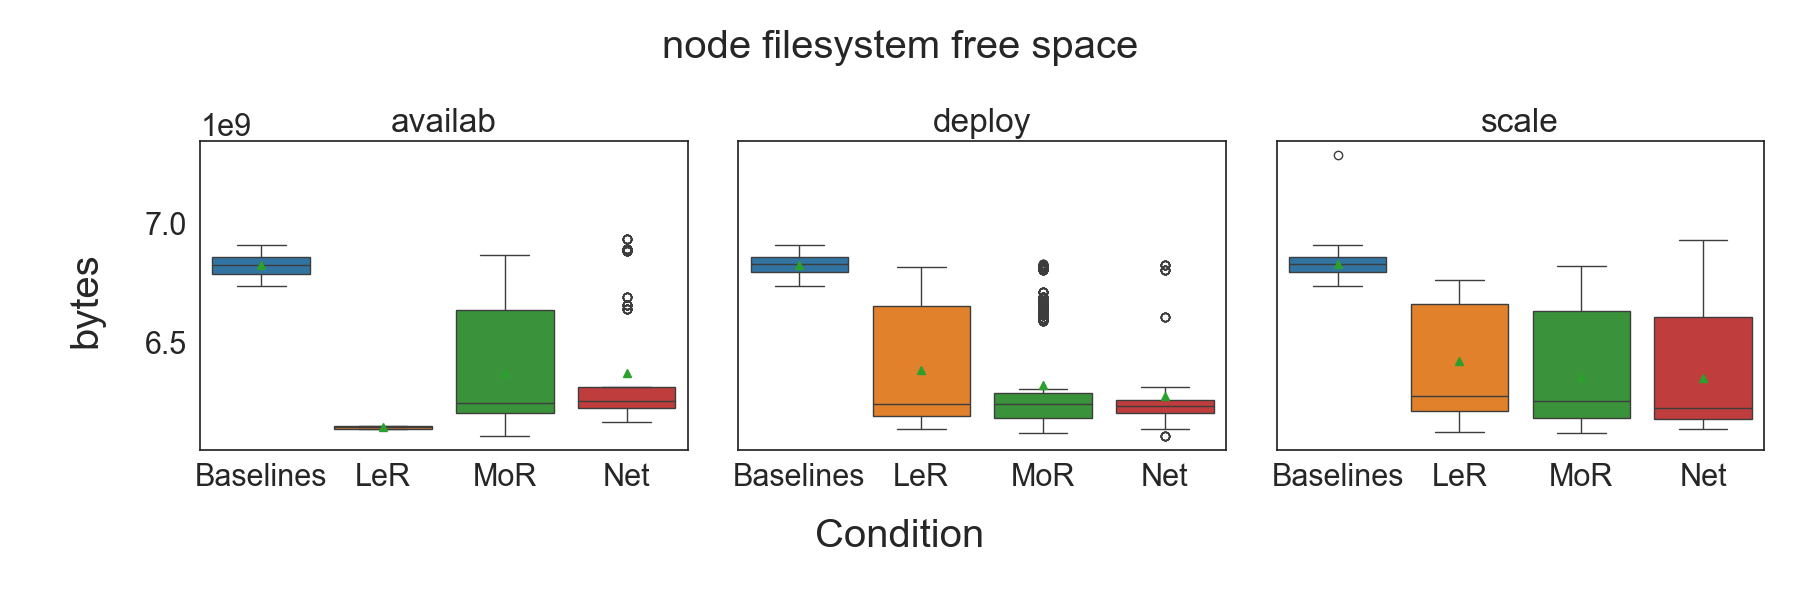

In [13]:
# Define desired metric names
metric_names_full = ['min node_filesystem_avail_bytes', 'min node_filesystem_free_bytes',]
metric_names = ['min node_filesystem_free_bytes',]
split_by = 'device'
device_to_skip = ["tmpfs", "shm",] 

print_metrics(metric_names, split_by, device_to_skip, plot_violin=False, title="node filesystem free space", y_label="bytes", show_split_by=False)
# print_metrics_heatmap(metric_names, split_by, device_to_skip)

In [ ]:
# Clean node file system bytes
del device_to_skip

<h4>node_filefd_allocated</h4>

In [ ]:
# Define desired metric names
metric_names = ['node_filefd_allocated',]

split_by = 'instance'

print_metrics(metric_names, split_by, [])
# print_metrics_heatmap(metric_names, split_by, [])

<h4>node_load5<h4>

In [ ]:
# Define desired metric names
metric_names = ['node_load5',]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Node memory</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["node_memory_Buffers_bytes", "node_memory_Cached_bytes", "node_memory_MemFree_bytes", "node_memory_Shmem_bytes", "node_memory_Slab_bytes", "node_memory_VmallocUsed_bytes"]
metric_names = ["node_memory_MemFree_bytes"]

split_by = 'instance'
to_skip = ["192.168.100.2:9100", "192.168.100.3:9100", "192.168.100.4:9100"]

print_metrics(metric_names, split_by, to_skip, title="Free node memory - master node", y_label="bytes", show_split_by=False)
# print_metrics_heatmap(metric_names, split_by, to_skip)

<h4>Node network stats</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["node_netstat_Tcp_CurrEstab", "node_procs_blocked", "node_sockstat_TCP_inuse", "node_sockstat_TCP_mem",]
metric_names = ["node_netstat_Tcp_CurrEstab"]

split_by = 'instance'
to_skip = ["192.168.100.2:9100", "192.168.100.3:9100", "192.168.100.4:9100"]

print_metrics(metric_names, split_by, to_skip, title="node tcp connection estabilished - master node", y_label="count", show_split_by=False)
# print_metrics(metric_names, split_by, [], value_to_show="sum_value")
# print_metrics_heatmap(metric_names, split_by, [], value_to_show="mean_value", show_numbers=True)
# print_metrics_heatmap(metric_names, split_by, [], title="TCP sockets in memory", y_label="max count", show_numbers=True, show_split_by=False)

<h4>Rates</h4>

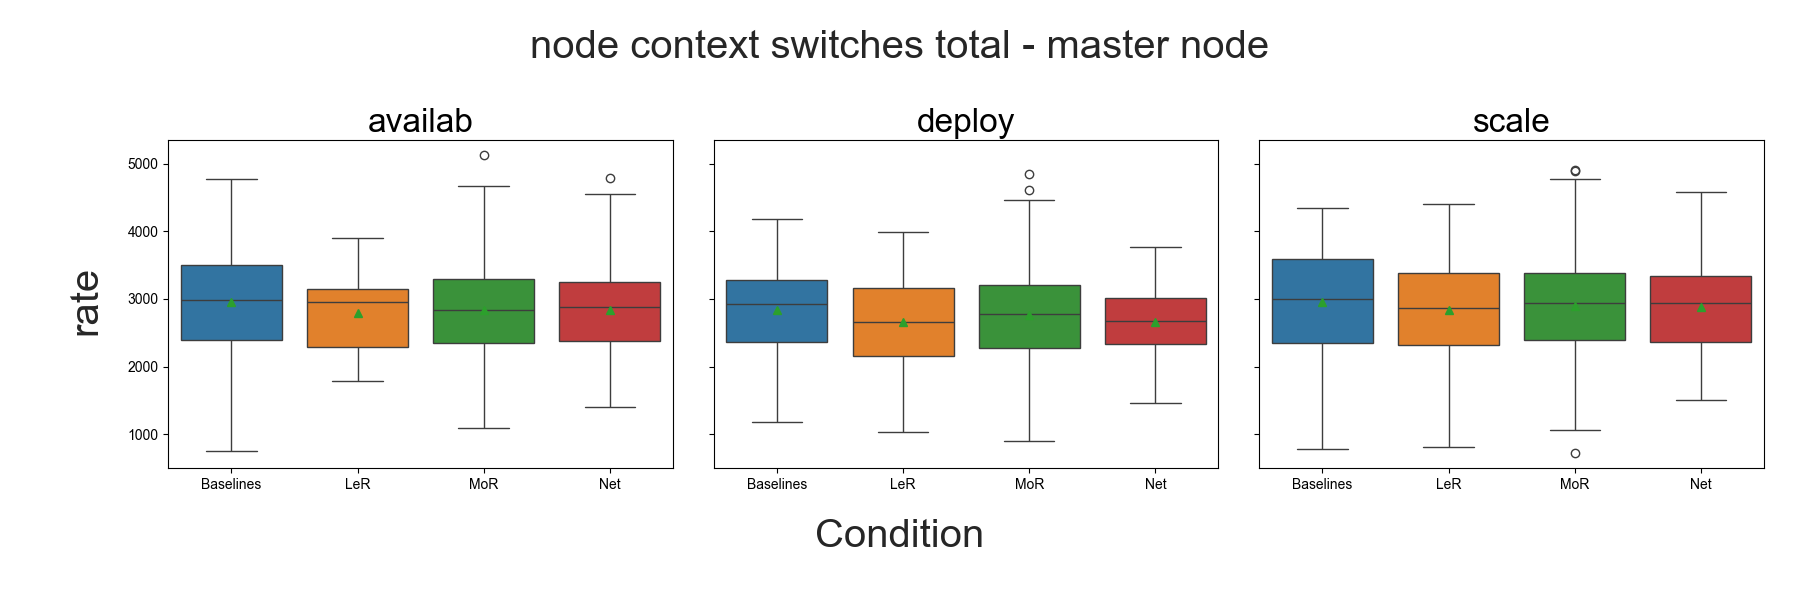

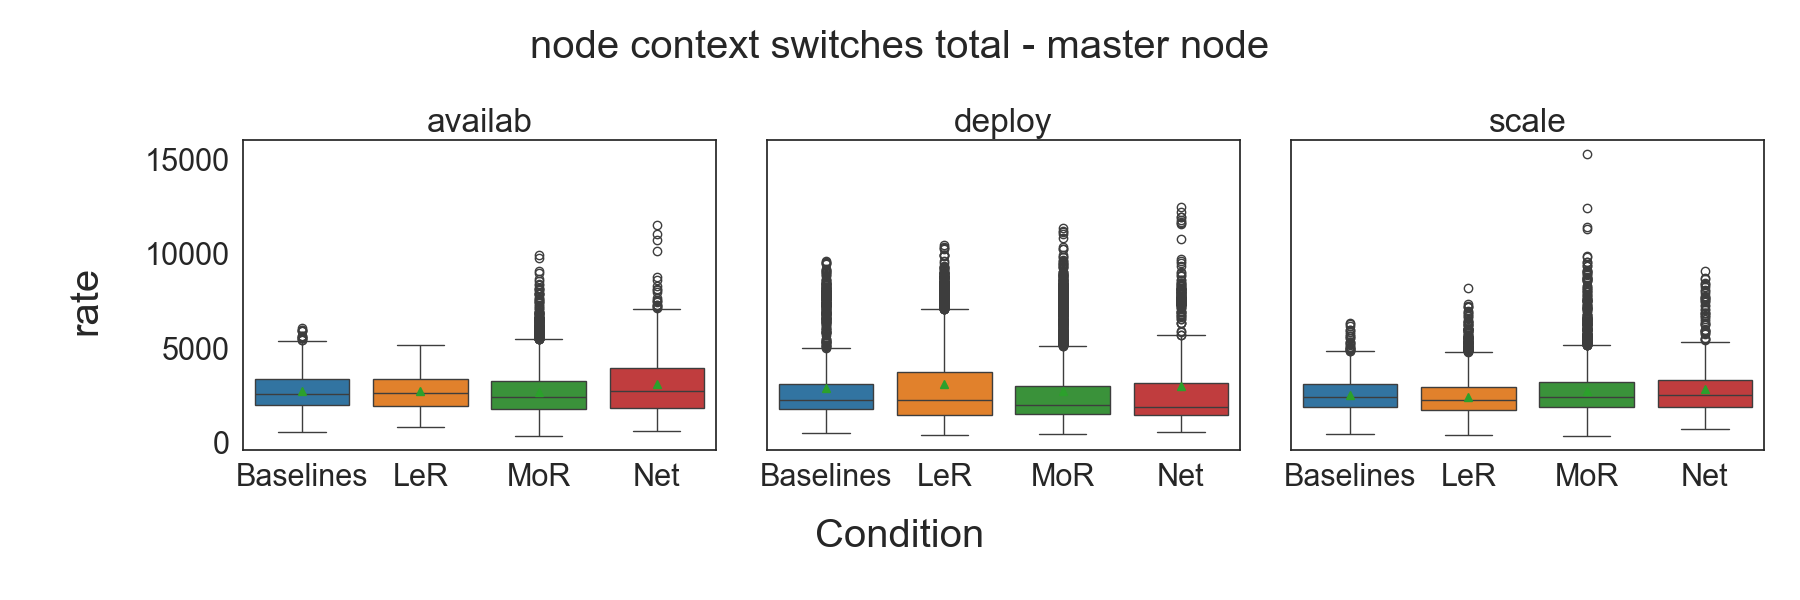

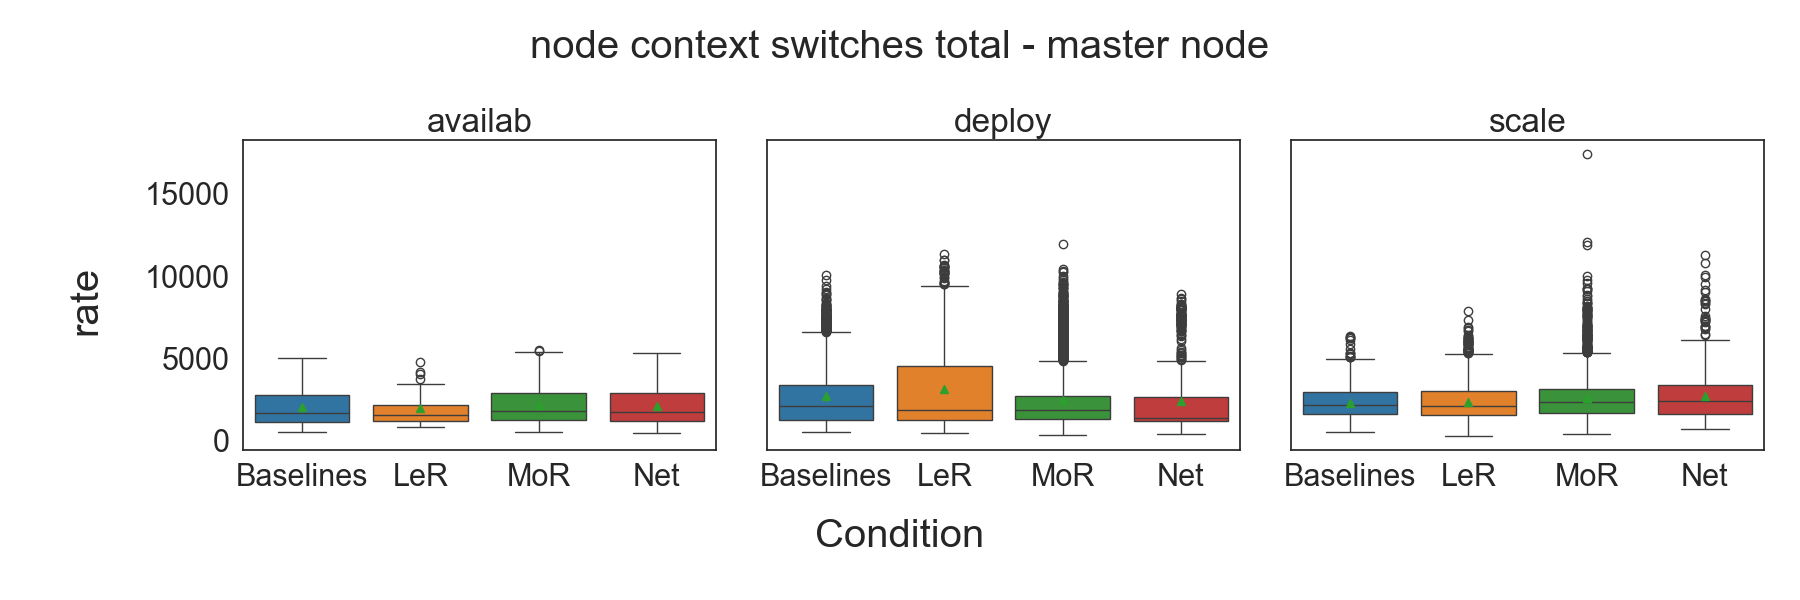

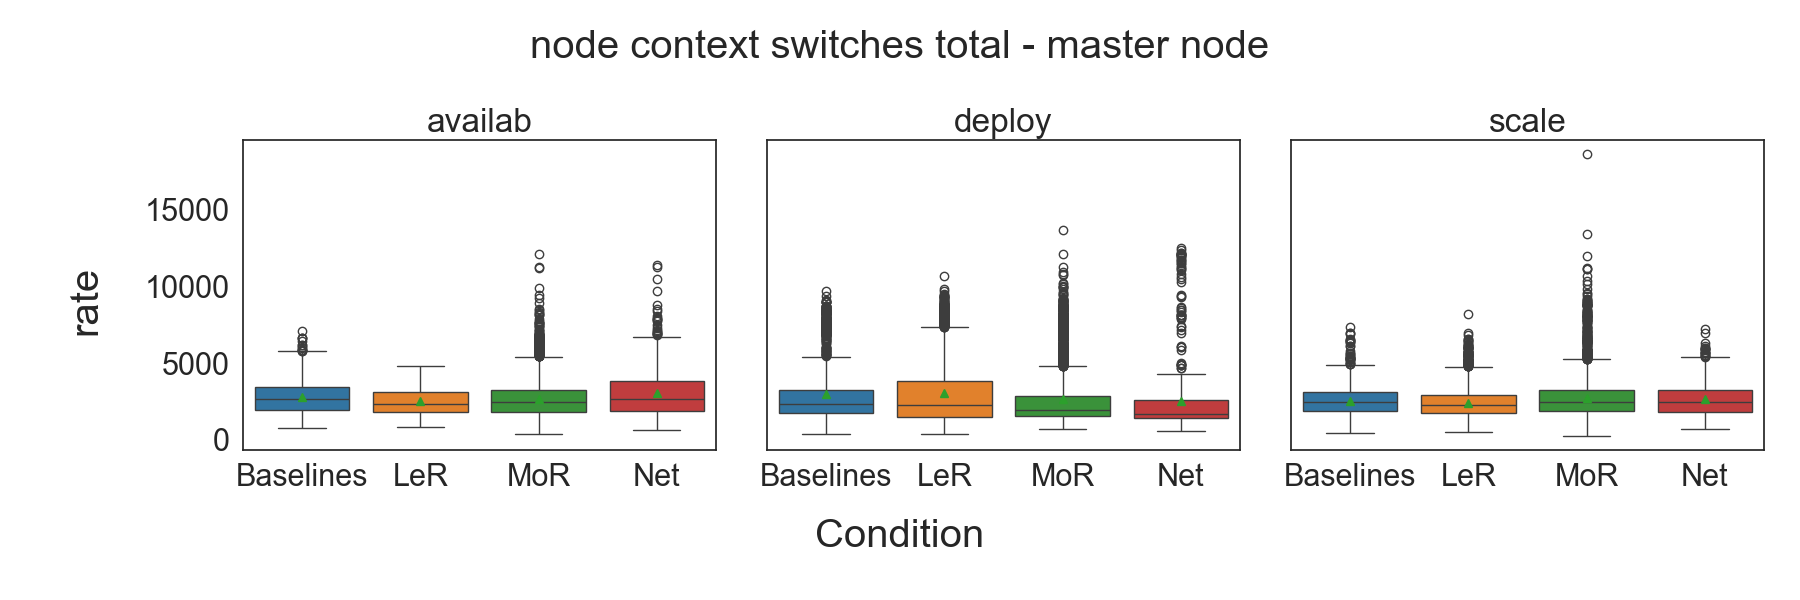

In [11]:
# Define desired metric names
metric_names_full = ["rate node_context_switches_total", "rate process_cpu_seconds_total", "rate process_resident_memory_bytes"]
metric_names = ["rate node_context_switches_total"]

split_by = 'instance'

print_metrics(metric_names, split_by, [], title="node context switches total - master node", y_label="rate", show_split_by=False)
# print_metrics_heatmap(metric_names, split_by, [], value_to_show="mean_value", show_numbers=True)

<h4>Node status capacity</h4>

In [ ]:
# Define desired metric names
metric_names = ["sum kube_node_status_capacity_offset_offset_time)_by_ resource)"]

split_by = 'resource'
to_skip = ["cpu", "hugepages_2Mi", "pods", "ephemeral_storage"]

print_metrics(metric_names, split_by, to_skip, title="node status capacity offset", y_label="sum of bytes")

<h4>Rate node network stats</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["sum rate node_netstat_Tcp_InErrs", "sum rate node_netstat_Tcp_RetransSegs", "sum rate node_network_carrier_changes_total", "sum rate node_network_receive_packets_total", "sum rate node_network_transmit_packets_total"]
metric_names = ["sum rate node_netstat_Tcp_RetransSegs"]

split_by = 'instance'
to_skip = ["192.168.100.2:9100", "192.168.100.3:9100", "192.168.100.4:9100"]

# print_metrics(metric_names, split_by, to_skip, title="packets rentransmitted", y_label="sum of rate")
print_metrics_heatmap(metric_names, split_by, to_skip, title="packets rentransmitted", y_label="sum of rate", show_numbers=True, show_split_by=False)

<h4>Node work queue</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["sum rate workqueue_adds_total", "sum rate workqueue_depth"]
metric_names = ["sum rate workqueue_depth"]

split_by = 'job'

# Filter DataFrame
df_filtered_by_name = df[df['name'].isin(metric_names)]

aggregated_df_splitted = df_filtered_by_name.groupby(['name', 'condition', 'workload', 'value']).agg(
    mean_value=('value', 'mean')
).reset_index().sort_values("condition")

for metric in metric_names:
    plot_metric_boxplot(aggregated_df_splitted, metric, f"tasks added to workqueue", y_label="sum of rate")
    plot_metric_heatmap(aggregated_df_splitted, metric, f"workqueue depth", y_label="sum of rate", show_numbers=True)

<h4>Status code</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["sum rate apiserver_request_total", "sum rate rest_client_requests_total"]
metric_names = ["sum rate rest_client_requests_total"]

split_by = 'status_code'

print_metrics(metric_names, split_by, [], title="rest client total requests", y_label="sum of rate")

<h4>Changes</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["changes kube_pod_container_status_restarts_total[10s]_offset_offset_time)___0", "changes kube_pod_status_phase[10s]_offset_offset_time)_!=_0"]
metric_names = ["changes kube_pod_status_phase[10s]_offset_offset_time)_!=_0"]

# split_by = 'container'
# to_skip = ["iello-dep", "hdllo-dep", "kube-proxy"]
# print_metrics(metric_names, split_by, to_skip, value_to_show="sum_value")
# print_metrics_heatmap(metric_names, split_by, to_skip, value_to_show="sum_value", title="container restarts total", y_label="sum", show_numbers=True)

split_by = 'job'
to_skip = ["Succeeded"]
# print_metrics(metric_names, split_by, to_skip, y_label="Sum", value_to_show="sum_value")
print_metrics_heatmap(metric_names, split_by, [], value_to_show="sum_value", title="pods status phase changes", y_label="sum", show_numbers=True, show_split_by=False)

<h4>Reason</h4>

In [ ]:
# Define desired metric names
metric_names_full = ["kube_pod_container_status_terminated_reason", "kube_pod_container_status_waiting_reason"]
metric_names = ["kube_pod_container_status_terminated_reason"]

split_by = ["reason"]
to_skip = ["iello-dep", "hdllo-dep", "kube-proxy", "completed", "kube-flannel", "ContainerStatusUnknown"]

# print_metrics(metric_names, split_by, to_skip, y_label="Sum", value_to_show="sum_value")
print_metrics_heatmap(metric_names, split_by, to_skip, title="container terminated reason", y_label="sum", value_to_show="sum_value", show_numbers=True)

<h3>Histograms</h3>

In [ ]:


metric_names_full = ["sum rate apiserver_request_duration_seconds_bucket", "sum rate rest_client_request_duration_seconds_bucket[10s]_offset_offset_time))_by_ le)", "sum rate workqueue_queue_duration_seconds_bucket"]
metric_names = ["sum rate rest_client_request_duration_seconds_bucket[10s]_offset_offset_time))_by_ le)"]

df_filtered_by_name = df[df['name'].isin(metric_names)]
df_grouped = df_filtered_by_name.groupby(['name', 'le', 'condition', 'workload']).agg(
        mean_value=('value', 'mean')
).reset_index().sort_values("le").sort_values("condition")

sns.set_theme(context="notebook", style="white", font_scale=1.2, palette="tab10")

for metric_name in metric_names:

        # Create subplots: 1 row and 3 columns (for the three workloads)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Iterate through each workload and corresponding subplot axis
        for i, workload in enumerate(["availab", "deploy", "scale"]):
                # Filter the DataFrame for the specific workload and create a copy
                filtered_df = df_grouped[df_grouped['workload'] == workload].copy()
                filtered_df = filtered_df[filtered_df['name'] == metric_name].copy()

                # Replace +Inf with a large finite value using .loc[]
                filtered_df.loc[filtered_df['le'] == float('inf'), 'le'] = 65

                # Filter by le value if necessary
                # filtered_df = filtered_df[filtered_df['le'] < 61]

                # Plotting the occurrence (frequency) histogram for all conditions in the same subplot
                ax = sns.histplot(x='le', y='mean_value', data=filtered_df, bins=70, hue='condition', palette="husl", ax=axes[i])
                axes[i].set_title(f'workload: {workload}')
                axes[i].set_xlabel('')
                axes[i].set_ylabel(' ')
                
                ticks = np.concatenate((np.arange(0, 10, step=2), np.arange(10, 61, step=10)))
                # Add the last tick with 'infinite' label
                ticks = np.append(ticks, 65)
                tick_labels = np.append(ticks[:-1], 'inf')
                
                ''' workqueue
                # Replace +Inf with a large finite value using .loc[]
                filtered_df.loc[filtered_df['le'] == float('inf'), 'le'] = 11

                # Filter by le value if necessary
                # filtered_df = filtered_df[filtered_df['le'] < 61]

                # Plotting the occurrence (frequency) histogram for all conditions in the same subplot
                ax = sns.histplot(x='le', y='mean_value', data=filtered_df, bins=60, hue='condition', palette="husl", ax=axes[i])
                axes[i].set_title(f'workload: {workload}')
                axes[i].set_xlabel('')
                axes[i].set_ylabel(' ')
                
                ticks = (np.arange(0, 11, step=2))
                # Add the last tick with 'infinite' label
                ticks = np.append(ticks, 11)
                tick_labels = np.append(ticks[:-1], 'inf')
                
                '''
                
                ax.set_xticks(ticks)
                ax.set_xticklabels(tick_labels)

                sns.move_legend(ax, "lower right")

        # Set the shared y-label
        fig.supylabel('requests per seconds rate')
        fig.supxlabel('le (request solved under x second)')
        fig.suptitle("rest client requests duration histogram", fontsize=16)
        fig.set_label(" ")
        # Adjust the layout for better spacing
        plt.tight_layout()
        plt.show()


In [92]:
# Clear histogram's vars
del ticks
del ax
del fig
del axes
del df_grouped
del df_filtered_by_name

In [ ]:
# Define the metrics and conditions to plot
metric_names_full = [
    "sum rate apiserver_request_duration_seconds_bucket", 
    "sum rate rest_client_request_duration_seconds_bucket[10s]_offset_offset_time))_by_ le)", 
    "sum rate workqueue_queue_duration_seconds_bucket"
]

metric_names = ["sum rate rest_client_request_duration_seconds_bucket[10s]_offset_offset_time))_by_ le)"]

df_filtered_by_name = df[df['name'].isin(metric_names)]
df_grouped = df_filtered_by_name.groupby(['name', 'le', 'condition', 'workload']).agg(
    mean_value=('value', 'mean')
).reset_index().sort_values("le").sort_values("condition")

for metric_name in metric_names:

    # Create subplots: 4 rows (for each condition) and 3 columns (for each workload)
    fig, axes = plt.subplots(4, 3, figsize=(18, 24), sharey=True)
    
    # Define conditions and workloads
    conditions = df_grouped['condition'].unique()
    workloads = ["availab", "deploy", "scale"]
    
    # Iterate through each condition
    for row_idx, condition in enumerate(conditions):
        
        # Iterate through each workload and corresponding subplot axis
        for col_idx, workload in enumerate(workloads):
            
            # Filter the DataFrame for the specific workload and condition
            filtered_df = df_grouped[(df_grouped['workload'] == workload) & (df_grouped['condition'] == condition)].copy()
            filtered_df = filtered_df[filtered_df['name'] == metric_name]
            
            # Replace +Inf with a large finite value using .loc[]
            filtered_df.loc[filtered_df['le'] == float('inf'), 'le'] = 65
            
            # Plotting the histogram for each condition and workload
            ax = sns.histplot(
                x='le', 
                y='mean_value', 
                data=filtered_df, 
                bins=15, 
                palette="husl", 
                hue="le",
                ax=axes[row_idx, col_idx],
                legend=False
            )
            
            # Set title and labels
            axes[row_idx, col_idx].set_title(f'Workload: {workload} - Condition: {condition}')
            axes[row_idx, col_idx].set_xlabel('le (request solved under x second)')
            axes[row_idx, col_idx].set_ylabel('requests per seconds rate' if col_idx == 0 else '')
            
            # Define ticks for le axis
            # ticks = np.concatenate((np.arange(0, 10, step=2), np.arange(10, 61, step=10)))
            # ticks = np.append(ticks, 65)
            # tick_labels = np.append(ticks[:-1], 'inf')
            
            # Set xticks and labels
            ax.set_xticks(ticks)
            ax.set_xticklabels(tick_labels)
            
            
    
    # Set the overall figure title
    fig.suptitle(f"{metric_name} Duration Histogram", fontsize=16)
    
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.show()

<h3>Times</h3>

In [ ]:
# print the time from when a
def print_time_metrics(metric_names_to_differ):
    # Filter DataFrame by metric names
    df_filtered = df[df['name'].isin(metric_names_to_differ)]

    # Define the necessary grouping columns
    group_by_columns = ['name', 'condition', 'workload', 'uid']
    group_by_columns2 = ['condition', 'workload', 'uid']

    # Aggregate data
    aggregated_df = df_filtered.groupby(group_by_columns).agg(
        mean_value=('value', 'mean')
    ).reset_index()

    aggregated_df_splitted = aggregated_df.groupby(group_by_columns2).agg(
        diff_value=('mean_value', lambda x: x.max() - x.min())
    ).reset_index()

    # Set up subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Plot each workload in separate subplots
    for i, workload in enumerate(["availab", "deploy", "scale"]):
        filtered_df = aggregated_df_splitted[aggregated_df_splitted['workload'] == workload]
        
        # Create a boxplot
        sns.boxplot(x='condition', y='diff_value', data=filtered_df, hue='condition', ax=axes[i])
        
        axes[i].set_title(workload)
        axes[i].set_xlabel('')
        axes[i].set_ylabel("seconds")

    # Set shared labels and title
    fig.supxlabel('Condition')
    fig.suptitle(f"pod created to containers started", fontsize=16)
    
    plt.tight_layout()
    plt.show()




# Define desired metric names
metric_names_full = ["kube_pod_container_state_started", "kube_pod_status_scheduled_time", "kube_pod_created", "kube_pod_start_time"]
metric_names = ["kube_pod_status_scheduled_time", "kube_pod_created"]
metric_names2 = ["kube_pod_status_scheduled_time", "kube_pod_container_state_started"]
metric_names3 = ["kube_pod_created", "kube_pod_container_state_started"]

print_time_metrics(metric_names)
print_time_metrics(metric_names2)
print_time_metrics(metric_names3)

# Check if exists data with a time difference
# inconsistent_data = df[(df['name'] == 'kube_pod_created') | (df['name'] == 'kube_pod_container_state_started')] \
#     .groupby('uid') \
#     .filter(lambda group: len(group['value'].unique()) > 1)

# print(inconsistent_data)

<h3>Verifica rapporto alert corretti / false segnalazioni </h3>

In [43]:
# rapporto alert missing e falsi per node_memory_MemFree_bytes

df_filtered_to_alert = df[df['name'].isin(["node_memory_MemFree_bytes"])]

# Filter out rows where 'instance' is in to_skip before grouping
to_skip = ["192.168.100.2:9100", "192.168.100.3:9100", "192.168.100.4:9100"] # worker nodes
df_filtered_to_alert_clear = df_filtered_to_alert[~df_filtered_to_alert['instance'].isin(to_skip)]

# group errors rows
group_by_columns = ['name', 'instance', 'condition', 'workload']
df_filtered_to_alert_clear_errors = df_filtered_to_alert_clear[~df_filtered_to_alert_clear['condition'].isin(["Baselines"])]

aggregated_df_splitted_errors = df_filtered_to_alert_clear.groupby(group_by_columns + ['value']).agg(
    mean_value=('value', 'mean'),
).reset_index().sort_values("condition")

# take baselines mean value
group_by_columns_mean_values = ['name', 'instance', 'condition']
aggregated_df_splitted_mean_values = df_filtered_to_alert_clear.groupby(group_by_columns_mean_values).agg(
    mean_value=('value', 'mean'),
).reset_index().sort_values("condition")


# Take the mean value of baselines and set the lower treshold as [mean value minus 15%]
baseline_mean_values = aggregated_df_splitted_mean_values[aggregated_df_splitted_mean_values['condition'] == 'Baselines']['mean_value'][0]
treshold = baseline_mean_values - ( baseline_mean_values * 0.15 )


under_treshold_rows = aggregated_df_splitted_errors[aggregated_df_splitted_errors['value'] < treshold]

under_treshold_rows_only_errors = under_treshold_rows[under_treshold_rows['condition'] != "Baselines"]

<h4> ALL FIELDS </h4>

In [ ]:
# print(field_group)
print_all = False

if print_all:
    for label, content in field_group.items():
        for metric in content:
            if not metric.isnumeric():
            
                print(f"\n{metric}")
                try:
                    # plot_metric_violin(df, metric)
                    plot_metric_boxplot(df, metric)
                except Exception as e:
                    print(e)
                    continue